# Avaliação do Desempenho na tarefa de classificação:

Importando bibliotecas necessárias:

In [1]:
import os
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext, DataFrame, functions as f, types as t, Window as w
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Transformer, PipelineModel
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer, NGram, VectorAssembler, Word2Vec, Word2VecModel, PCA
from pyspark.ml.linalg import VectorUDT, Vectors
from sparknlp.base import *
from sparknlp.annotator import *
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

2022-02-13 09:18:51.756643: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-13 09:18:51.756676: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
os.environ['TFHUB_CACHE_DIR'] = '~/.cache/tfhub_modules'
os.environ['JAVA_HOME'] = '/usr/lib/jvm/java-11-openjdk-amd64'

Criando sessão do Spark:

In [ ]:
spark = SparkSession.builder \
    .master("local[*]") \
    .config("spark.driver.memory","16G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.12:3.3.4") \
    .getOrCreate()

In [33]:
from sparknlp.pretrained import UniversalSentenceEncoder

In [34]:
BASE_PATH = '../'

Carregamento dos dados:

In [24]:
df = spark.read.parquet(BASE_PATH + "wikilinks-fulldata.parquet")
    .na.drop()
    .dropDuplicates(['context_left', 'context_middle', 'context_right'])

In [29]:
df = df.withColumn('wiki_url', f.lower(f.col('wiki_url')))

In [28]:
df.filter(f.col('wiki_url').contains('degli_Studi_di')).count()

1

In [ ]:
print(df.select('wiki_url', 'full_context').limit(15).toPandas().to_latex(index=False))

+--------------------+-----------------+---------------+--------------------+-----------------+--------------------+--------------------+
|            wiki_url|      anchor_text|raw_text_offset|        context.left|   context.middle|       context.right|         freebase_id|
+--------------------+-----------------+---------------+--------------------+-----------------+--------------------+--------------------+
|http://en.wikiped...|Rorschach inkblot|           8608|such by everyone....|Rorschach inkblot|. In between thes...|9202a8c04000641f8...|
+--------------------+-----------------+---------------+--------------------+-----------------+--------------------+--------------------+
only showing top 1 row



In [10]:
df = df.withColumn('full_context', f.concat_ws(' ', f.col('context_left'), f.col('context_middle'), f.col('context_right')))

In [8]:
df.select('wiki_url') \
    .groupBy('wiki_url') \
    .agg(f.count('wiki_url').alias('#mentions')).toPandas()

,wiki_url,#mentions
0,http://en.wikipedia.org/wiki/bread,612
1,http://en.wikipedia.org/wiki/science_fiction_film,606
2,http://en.wikipedia.org/wiki/chess,776
3,http://en.wikipedia.org/wiki/kansas,757
4,http://en.wikipedia.org/wiki/dorset,741
...,...,...
94,"http://en.wikipedia.org/wiki/buffalo,_new_york",510
95,http://en.wikipedia.org/wiki/the_wall_street_j...,585
96,http://en.wikipedia.org/wiki/balkans,668
97,"http://en.wikipedia.org/wiki/st._louis,_missouri",800


In [8]:
classes = [row.wiki_url for row in df.select('wiki_url').distinct().collect()]

Divisão em treino e teste:

In [10]:
train_factor = 0.75
train_fractions = {cls: train_factor for cls in classes} 
train_df = df.sampleBy("wiki_url", fractions=train_fractions, seed=42)
test_df = df.join(train_df, on=["wiki_url"], how="left_anti")

Geração dos *sentence embeddings* utilizando o Universal Sentence :

In [11]:
def use_embedding(df, columns):
    stages = []
    for col in columns:
        document = DocumentAssembler().setInputCol(col).setOutputCol(col + "_doc")
        use_embed = UniversalSentenceEncoder.pretrained() \
            .setInputCols(col + "_doc") \
            .setOutputCol(col + "_use_encoding")
        stages = stages + [document, use_embed]
    embed_pipeline = Pipeline(stages=stages)
    model = embed_pipeline.fit(df)
    output = model.transform(df)
    return output

In [12]:
train_df_use_embedding = use_embedding(train_df, ['full_context'])

tfhub_use download started this may take some time.
Approximate size to download 923,7 MB
[ | ]tfhub_use download started this may take some time.
Approximate size to download 923,7 MB
Download done! Loading the resource.
[ \ ]

2022-01-12 16:34:13.169923: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-12 16:34:13.349720: I external/org_tensorflow/tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2803000000 Hz


[OK!]


In [13]:
test_df_use_embedding = use_embedding(test_df, ['full_context'])

tfhub_use download started this may take some time.
Approximate size to download 923,7 MB
[OK!]


In [ ]:
classsifierdl = ClassifierDLApproach() \
  .setInputCols(["full_context_use_encoding"]) \
  .setOutputCol("class") \
  .setLabelColumn("wiki_url") \
  .setMaxEpochs(1200) \
  .setBatchSize(100) \
  .setEnableOutputLogs(True) \
  .setLr(1e-2) \
  .setDropout(0.01)

use_clf_pipeline = Pipeline(stages = [classsifierdl])

In [ ]:
retrain = False

In [16]:
if retrain:
    use_pipelineModel = use_clf_pipeline.fit(train_df_use_embedding)
    use_pipelineModel.write().overwrite().save(BASE_PATH + "use_trained_classifier")

In [17]:
if not retrain:
    use_pipelineModel = PipelineModel.load(BASE_PATH + "use_trained_classifier")

In [18]:
pred = use_pipelineModel.transform(test_df_use_embedding)

*Classification report* do Scikit Learn no conjunto de teste:

In [19]:
pred_df = pred.select('wiki_url',"class.result").toPandas()
pred_df['result'] = pred_df['result'].apply(lambda x: x[0])

print(classification_report(pred_df.wiki_url, pred_df.result))

/home/samir/miniconda3/envs/ds/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                 precision    recall  f1-score   support

                              http://en.wikipedia.org/wiki/1960       0.00      0.00      0.00       200
               http://en.wikipedia.org/wiki/2010_fifa_world_cup       0.86      0.93      0.89       175
                    http://en.wikipedia.org/wiki/abdominal_pain       0.97      0.93      0.95       206
                     http://en.wikipedia.org/wiki/aldous_huxley       0.00      0.00      0.00       148
                        http://en.wikipedia.org/wiki/azerbaijan       0.59      0.65      0.62       187
                           http://en.wikipedia.org/wiki/balkans       0.74      0.69      0.71       195
                        http://en.wikipedia.org/wiki/black_hole       0.37      0.92      0.53       253
                    http://en.wikipedia.org/wiki/blood_pressure       0.89      0.90      0.90       256
                         http://en.wikipedia.org/wiki/

/home/samir/miniconda3/envs/ds/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/samir/miniconda3/envs/ds/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 50460)
Traceback (most recent call last):
  File "/home/samir/miniconda3/envs/ds/lib/python3.9/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/home/samir/miniconda3

(Trabalhos futuros) Avaliação do modelo BERT para geração dos sentence embeddings

In [16]:
# def bert_embedding(df, columns):
#     stages = []
#     for col in columns:
#         document = DocumentAssembler().setInputCol(col).setOutputCol(col + "_doc")
#         stages.append(document)
        
#     for col in columns:
#         # bert_embed = BertSentenceEmbeddings.pretrained("sent_bert_large_cased", "en") \
#         bert_embed = BertSentenceEmbeddings.pretrained("sent_small_bert_L8_512", "en") \
#             .setInputCols(col + "_doc") \
#             .setOutputCol(col + "_bert_encoding")
#         stages.append(bert_embed)
#     embed_pipeline = Pipeline(stages=stages)
#     model = embed_pipeline.fit(df)
#     output = model.transform(df)
#     return output

In [17]:
# df_bert_embedding = bert_embedding(df, ['full_context'])

sent_small_bert_L8_512 download started this may take some time.
Approximate size to download 149,1 MB
[OK!]


In [ ]:
# classsifierdl = ClassifierDLApproach() \
#   .setInputCols(["full_context_bert_encoding"]) \
#   .setOutputCol("class") \
#   .setLabelColumn("wiki_url") \
#   .setMaxEpochs(500) \
#   .setBatchSize(100) \
#   .setEnableOutputLogs(True) \
#   .setLr(1e-2) \
#   .setDropout(0.01)

# bert_clf_pipeline = Pipeline(stages = [classsifierdl])
# bert_pipelineModel = bert_clf_pipeline.fit(df_bert_embedding)
# pred = bert_pipelineModel.transform(df_bert_embedding)

In [ ]:
# pred_df = pred.select('wiki_url',"class.result").toPandas()
# pred_df['result'] = pred_df['result'].apply(lambda x: x[0])

# print(classification_report(pred_df.wiki_url, pred_df.result))

## Análise das similaridas para os *sentence embeddings* gerados pelo BERT e o Universal Sentence Encoder

In [17]:
def finish_embeddings(df, columns):
    stages = []
    for col in columns:
        finisher = EmbeddingsFinisher() \
          .setInputCols(col) \
          .setOutputCols(col + "_vector") \
          .setOutputAsVector(True)
        stages.append(finisher)
    pipeline = Pipeline(stages=stages)
    model = pipeline.fit(df)
    output = model.transform(df)
    for col in columns:
        output = output.withColumn(col + "_vector", f.col(col + "_vector")[0])
    return output

In [ ]:
df_embedding = finish_embeddings(df_embedding, ['context_left_use_encoding',
                                                'context_left_bert_encoding',
                                                'context_right_use_encoding',
                                                'context_right_bert_encoding'])

In [19]:
entities = [
    df_embedding.filter(f.col('wiki_url') == 'http://en.wikipedia.org/wiki/naruto').collect(),
    df_embedding.filter(f.col('wiki_url') == 'http://en.wikipedia.org/wiki/solar_panel').collect(),
    df_embedding.filter(f.col('wiki_url') == 'http://en.wikipedia.org/wiki/html5').collect()
]

In [20]:
def cosine(x, y):
    return x.dot(y) / (x.norm(2) * y.norm(2))

In [21]:
def flatten(l):
    return list(itertools.chain(*l))

In [22]:
def sim_matrix(embeddings):
    n = len(embeddings)
    m = np.zeros((n, n))
    for i in range(n):
        x = embeddings[i]
        for j in range(n):
            y = embeddings[j]
            m[i, j] = cosine(x, y)
    return m

In [23]:
entities_use_left_embeddings = [
    [row.context_left_use_encoding_vector for row in entity]
    for entity in entities
]
entity_left_use_sims = sim_matrix(flatten(entities_use_left_embeddings))

In [24]:
entities_use_right_embeddings = [
    [row.context_right_use_encoding_vector for row in entity]
    for entity in entities
]
entity_right_use_sims = sim_matrix(flatten(entities_use_right_embeddings))

In [25]:
entities_bert_left_embeddings = [
    [row.context_left_bert_encoding_vector for row in entity]
    for entity in entities
]
entity_left_bert_sims = sim_matrix(flatten(entities_bert_left_embeddings))

In [26]:
entities_bert_right_embeddings = [
    [row.context_right_bert_encoding_vector for row in entity]
    for entity in entities
]
entity_right_bert_sims = sim_matrix(flatten(entities_bert_right_embeddings))

In [27]:
def plot_sim_matrix(sim_matrix):
    n = sim_matrix.shape[0]
    fig, ax = plt.subplots(figsize=(20,20))
    cax = ax.matshow(sim_matrix, interpolation='nearest')
    ax.grid(False)
    plt.xticks(range(n), rotation=90);
    plt.yticks(range(n));
    fig.colorbar(cax, ticks=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, .75,.8,.85,.90,.95,1])
    plt.show()

In [28]:
entities[1][4].context_left

'are now $4.29 a\xa0Gallon Posted on April 4, 2012 | 10 Comments Solyndra Not Sole Firm to Hit Rock Bottom Despite Stimulus Funding Solyndra, the'

In [29]:
entities[1][11].context_left

'have gone BOOM! Perhaps you should have Drilled Baby Drilled Mr. President Solyndra Not Sole Firm to Hit Rock Bottom Despite Stimulus Funding Solyndra, the'

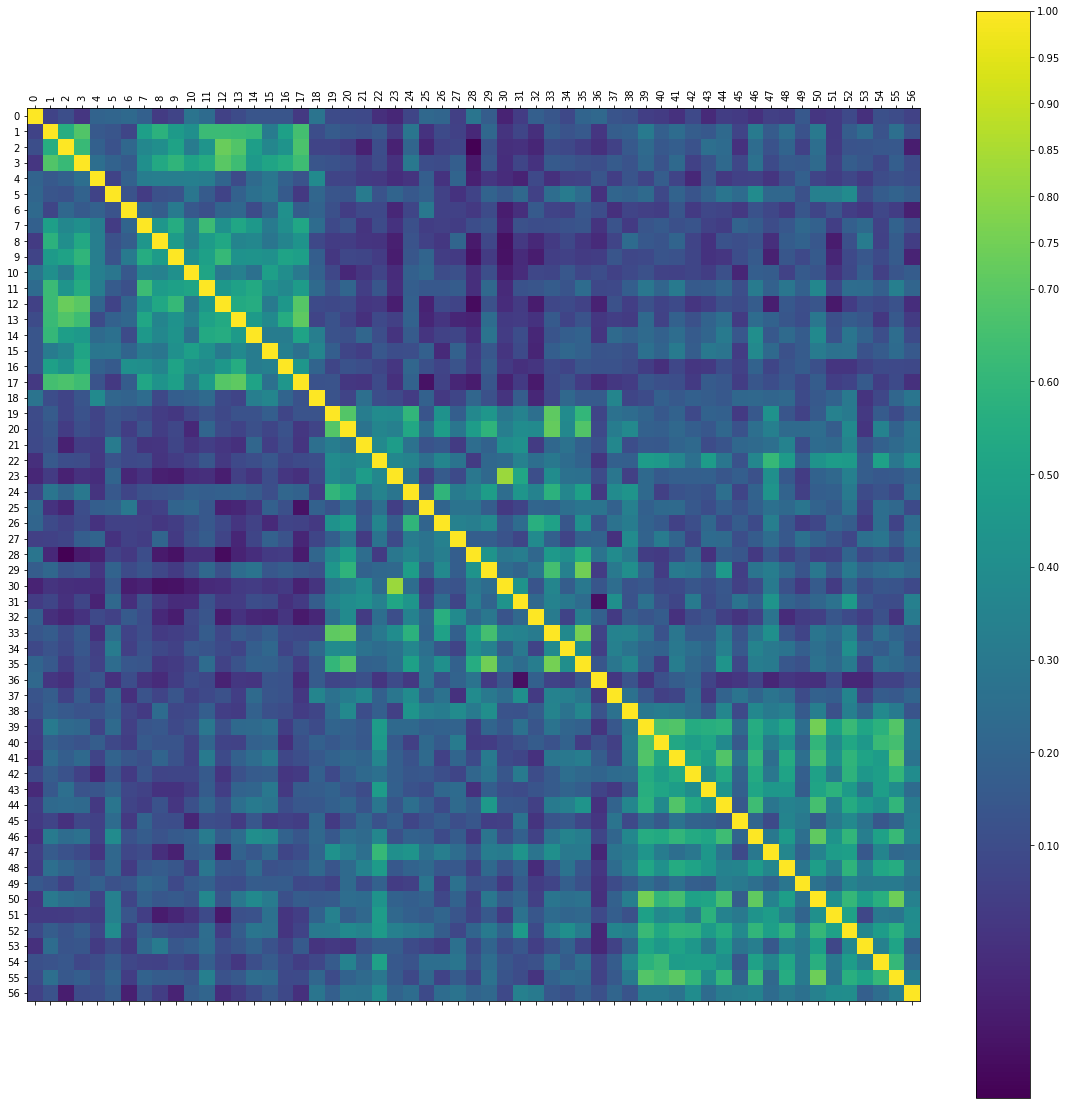

In [30]:
plot_sim_matrix(entity_left_use_sims)

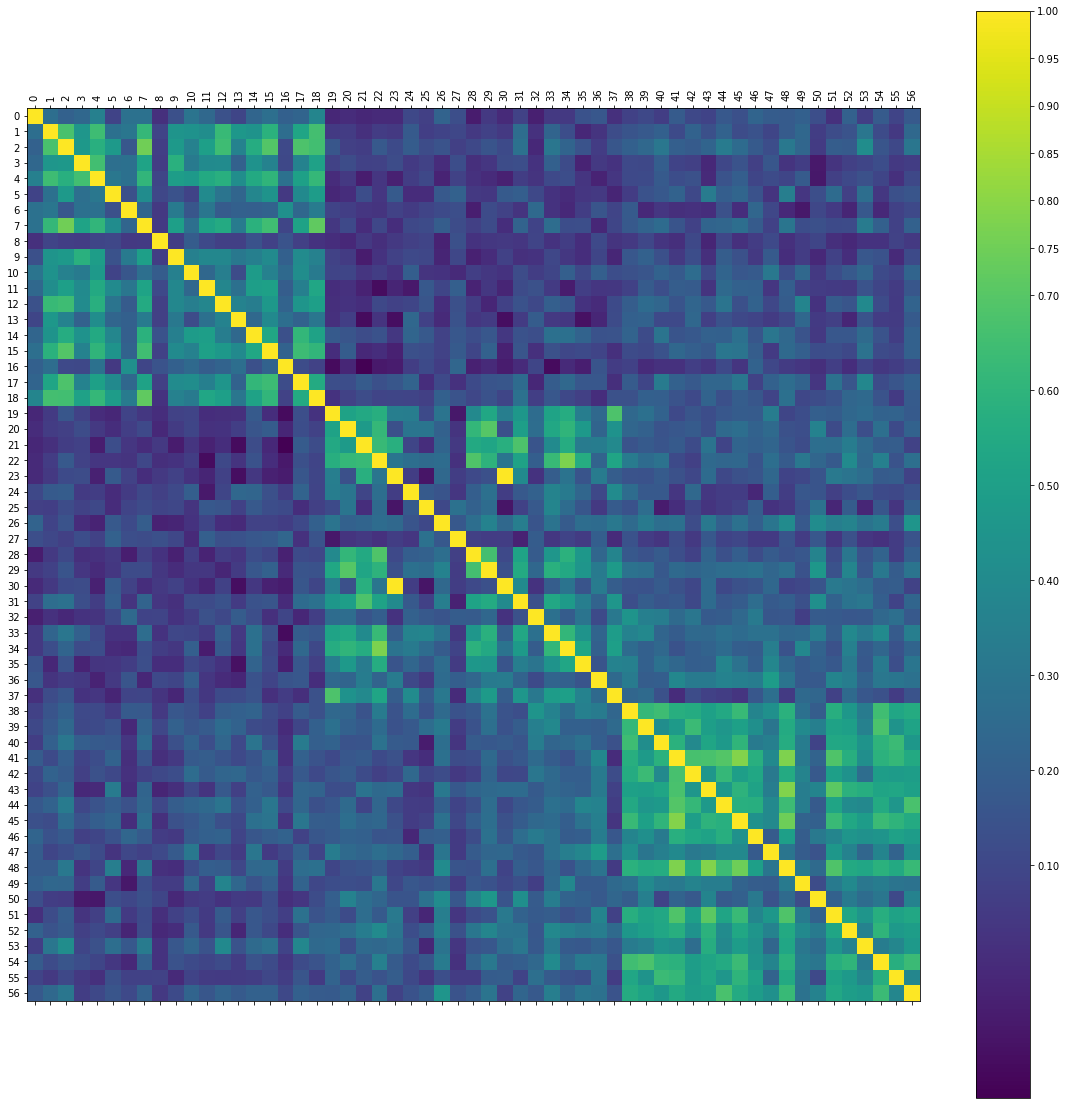

In [31]:
plot_sim_matrix(entity_right_use_sims)

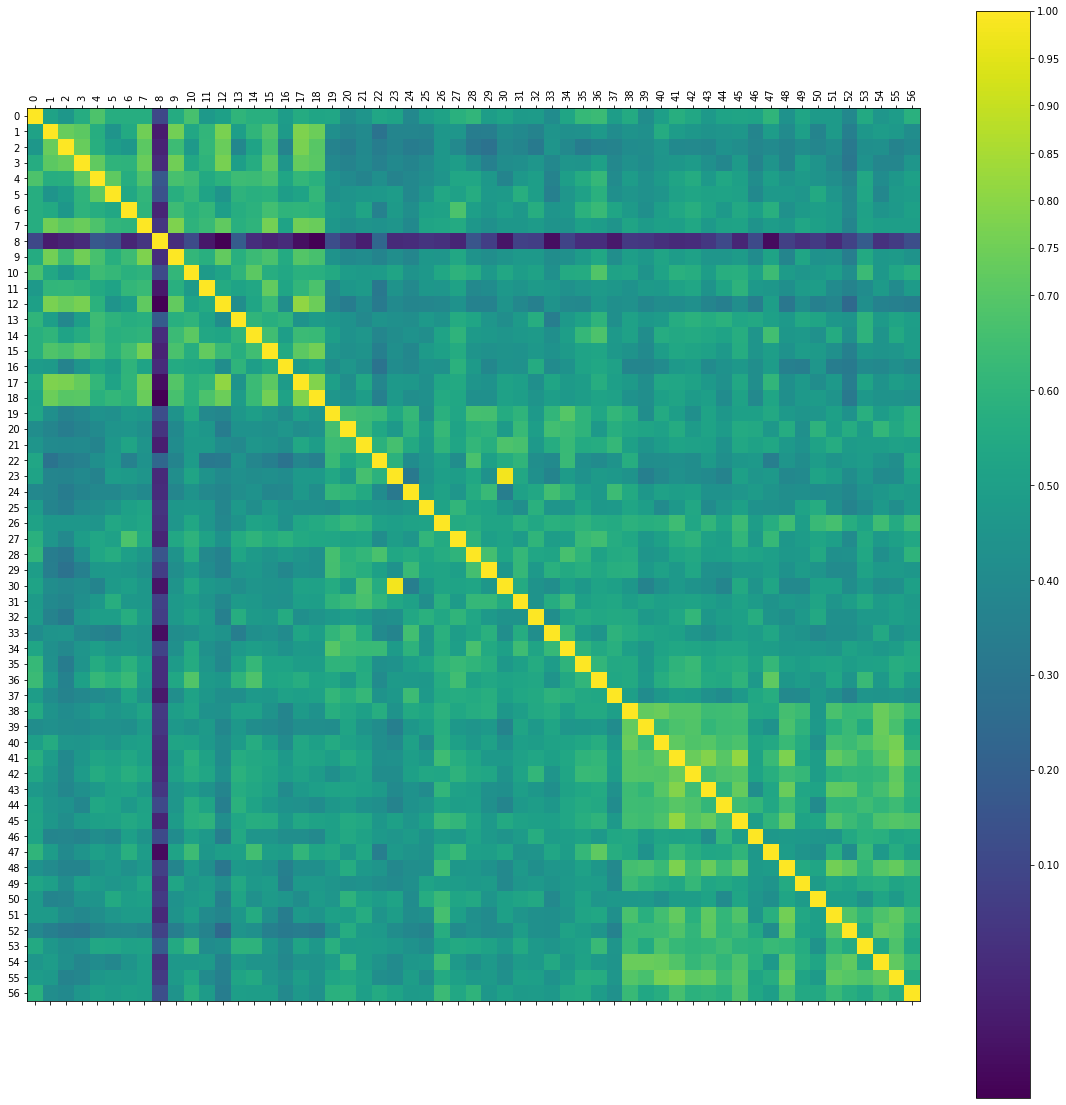

In [32]:
plot_sim_matrix(entity_left_bert_sims)

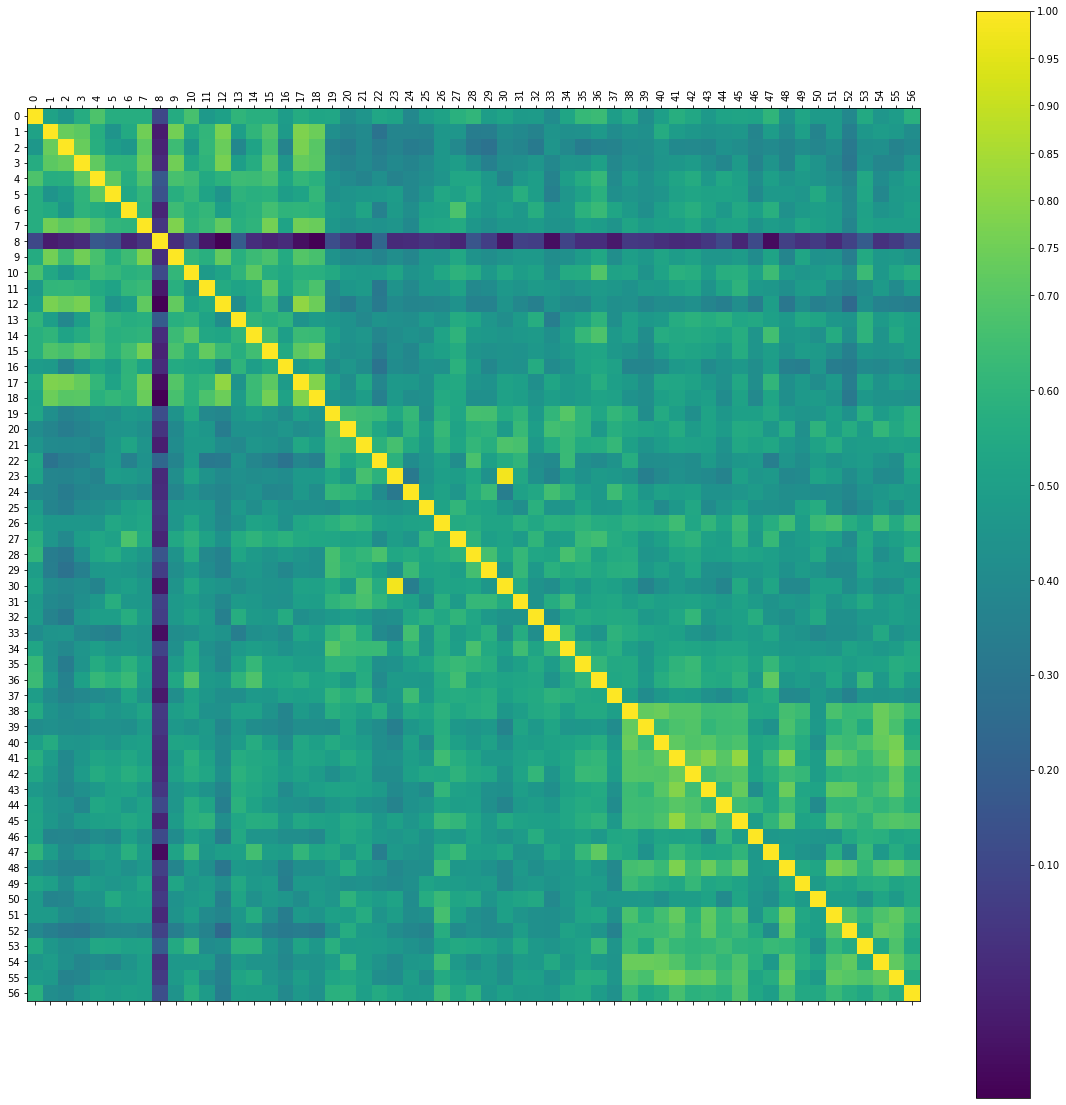

In [33]:
plot_sim_matrix(entity_right_bert_sims)

### Avaliando com redução de dimensionalidade feita pelo PCA

In [34]:
def embedding_reduction(df, k, columns):
    stages = []
    for col in columns:
        pca = PCA(k=k, inputCol=col).setOutputCol(col + "_reduced")
        stages = stages + [pca]

    embed_pipeline = Pipeline(stages=stages)
    model = embed_pipeline.fit(df)
    output = model.transform(df)
    return output

In [35]:
df_reduced = embedding_reduction(df_embedding, 100, ['context_left_bert_encoding_vector',
                                                     'context_right_bert_encoding_vector',
                                                     'context_left_use_encoding_vector',
                                                     'context_right_use_encoding_vector'])

In [36]:
entities_reduced = [
    df_reduced.filter(f.col('wiki_url') == 'http://en.wikipedia.org/wiki/naruto').collect(),
    df_reduced.filter(f.col('wiki_url') == 'http://en.wikipedia.org/wiki/solar_panel').collect(),
    df_reduced.filter(f.col('wiki_url') == 'http://en.wikipedia.org/wiki/html5').collect()
]

In [37]:
entities_use_right_embeddings_reduced = [
    [row.context_right_use_encoding_vector_reduced for row in entity]
    for entity in entities_reduced
]
entity_right_use_reduced_sims = sim_matrix(flatten(entities_use_right_embeddings_reduced))

In [38]:
entities_bert_right_embeddings_reduced = [
    [row.context_right_bert_encoding_vector_reduced for row in entity]
    for entity in entities_reduced
]
entity_right_bert_reduced_sims = sim_matrix(flatten(entities_bert_right_embeddings_reduced))

In [39]:
entities_bert_left_embeddings_reduced = [
    [row.context_left_bert_encoding_vector_reduced for row in entity]
    for entity in entities_reduced
]
entity_left_bert_reduced_sims = sim_matrix(flatten(entities_bert_left_embeddings_reduced))

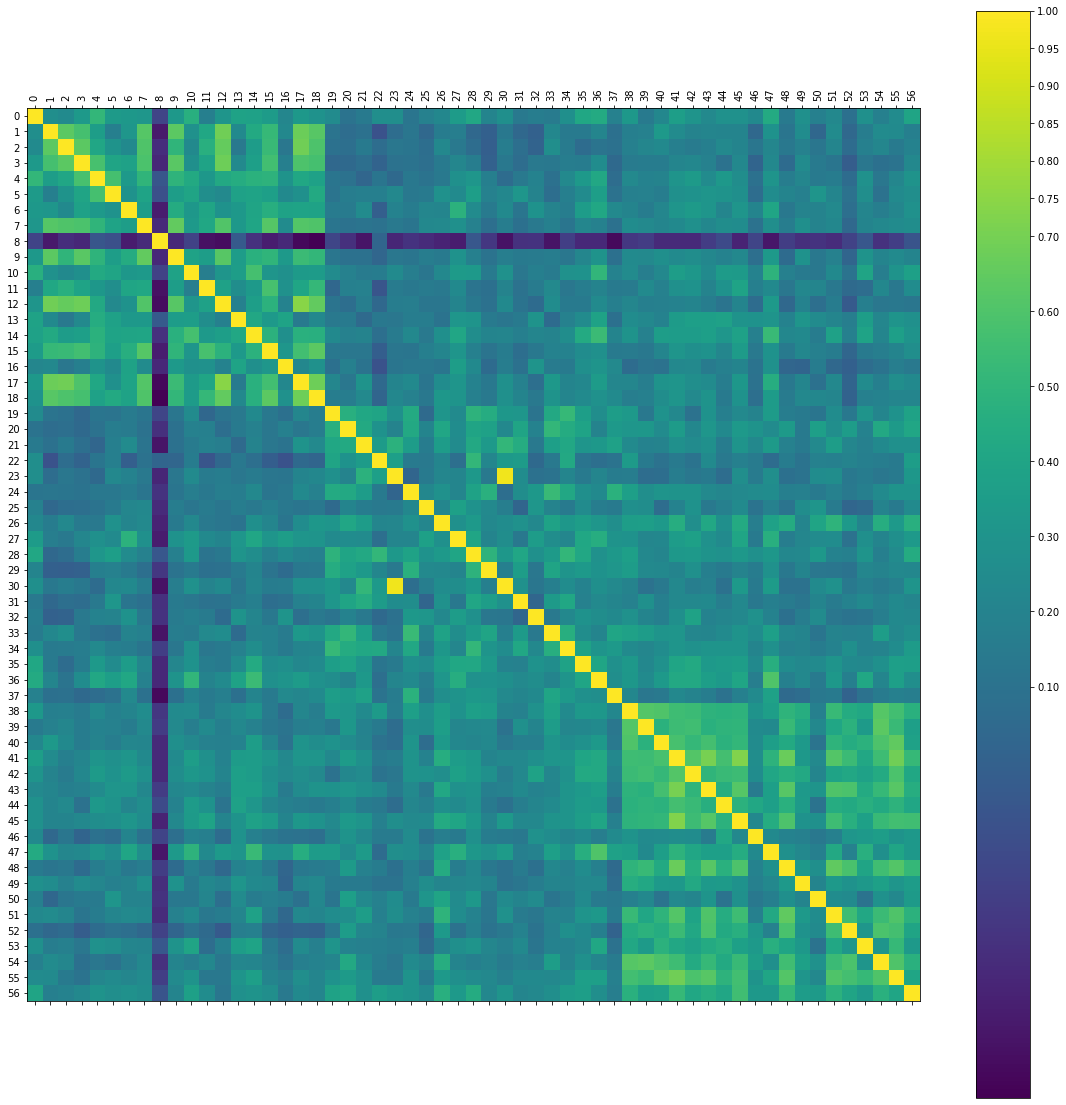

In [40]:
plot_sim_matrix(entity_right_bert_reduced_sims)

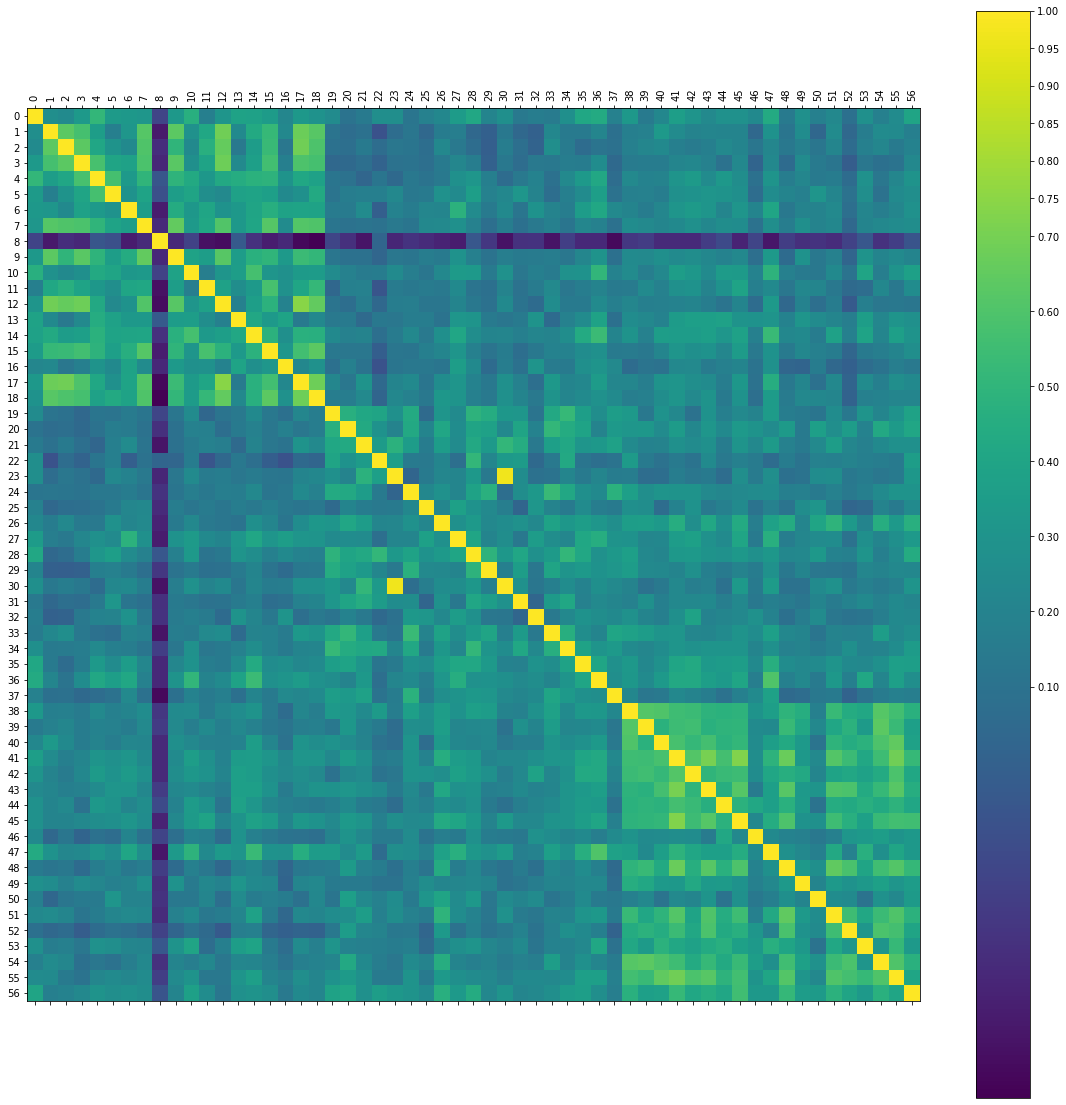

In [41]:
plot_sim_matrix(entity_left_bert_reduced_sims)

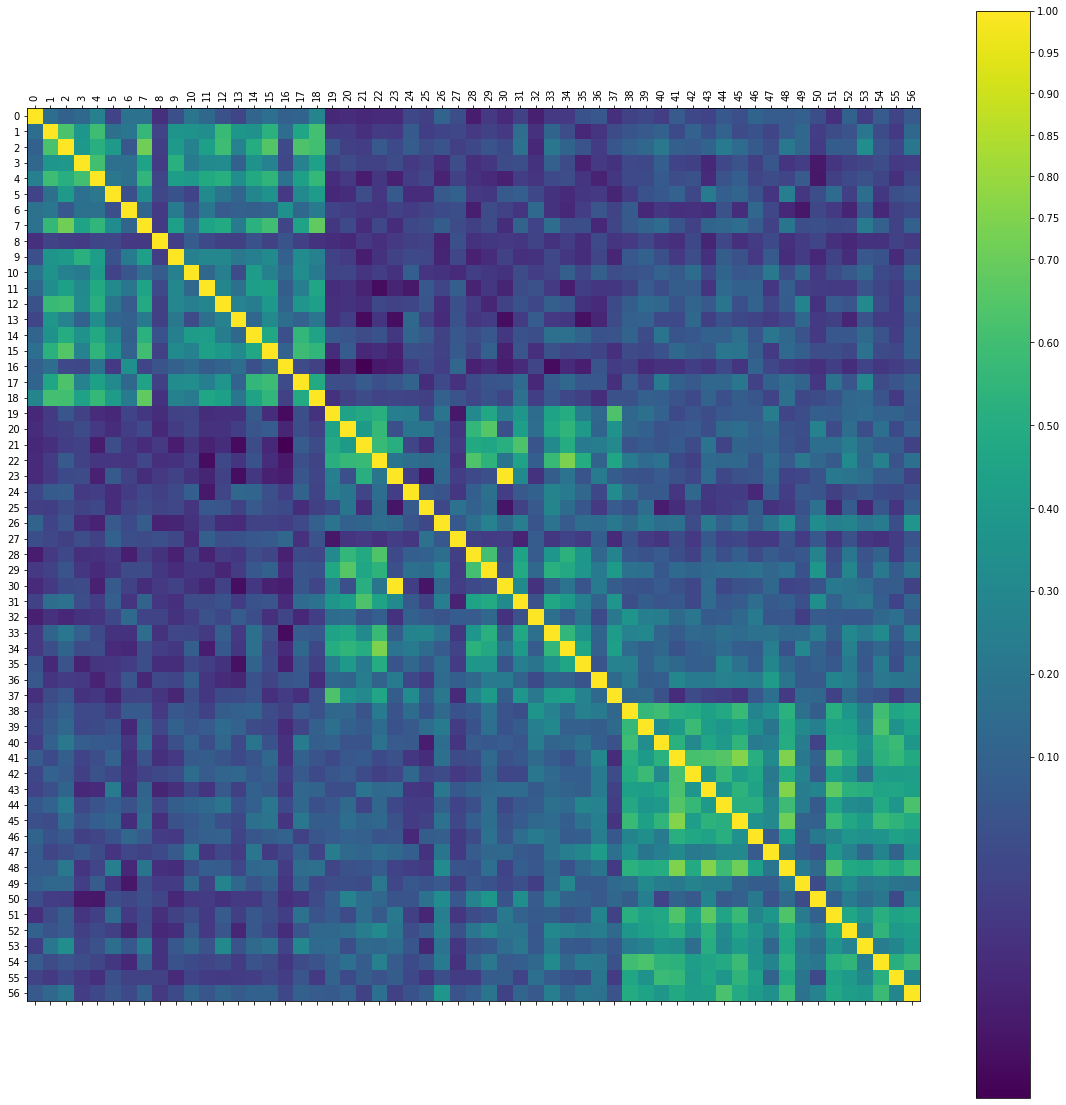

In [42]:
plot_sim_matrix(entity_right_use_reduced_sims)